# โมเดล Predict Solar Power Model_1

เริ่มด้วยการ Import library ต่างๆ
- import keras - keras เป็น Deep Learning Library ในภาษา Python ที่ทำงานบน TensorFlow และ Theano

In [45]:
#import ข้อมูลใน google drive ของเราเข้ามา
!ln -s ../data/ ./
!ln -s ../out/ ./

ln: failed to create symbolic link './data': File exists
ln: failed to create symbolic link './out': File exists


In [30]:
import os
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ขั้นที่ 1 โหลด CSV ไพล์ สำหรับใช้ Train โมเดล

In [31]:
#โหลด CSV ไพล์ สำหรับ train โมเดล ซึ่ง CSV ไพล์ของเราประกอบไปด้วย 9 colunm คือ
#1. datetime เป็น datetime คั้งแต่ปี 2017-2018 ระหว่างเวลา 6 pm to 6 am
#2. date เป็น date ตั้งแต่ปี 2017-2018
#3. time เป็น time ตั้งแต่ 6 pm - 6 am
#4. I ; Solar irradiance (W/m2)
#5. T ; Temperature (oC*10)
#6. UV ; UV index (UV index*10)
#7. WS ; Wind speed (m/s*10)
#8. RH ; Relative humidity (%)
#9. P ; Solar power (W*min)

#ไว้ในตัวแปร train ซึ่งคำสั่ง pd.read_csv จะได้ตัวแปรที่มี type เป็น dataframe
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')

#เก็บ column datetime ไว้ในตัวแปรที่ชื่อ buffer_datetime_train เพื่อ ...
buffer_datetime_train = train.datetime

#Remove column ที่มี type เป็น object นั่นคือคอลัม datetime, date, และ time
train = train.select_dtypes(exclude=['object'])

#แทนที่ misssing value ด้วย 0
train.fillna(0,inplace=True)

# ขั้นที่ 2 โหลด CSV ไพล์สำหรับใช้เป็น Unseen Data เพื่อใช้ทดสอบโมเดล

In [32]:
#โหลด csv ไพล์สำหรับเป็น unseen data เพื่อใช้ทดสอบโมเดล
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')

#เก็บ column datetime ไว้ในตัวแปรที่ชื่อ buffer_datetime_train เพื่อ ...
buffer_datetime_test = test.datetime

#Remove column ที่มี type เป็น object
test = test.select_dtypes(exclude=['object'])

#แทนที่ misssing value ด้วย 0
test.fillna(0,inplace=True)

# ขั้นที่ 3 Print เพื่อดู dimension ของ train และ test 

In [33]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


# ขั้นที่ 4 Print เพื่อดู feature ใน train ว่าประกอบไปด้วย feature อะไรบ้าง

In [34]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# ขั้นที่ 5 Remove Outlier

In [35]:
#import library ที่ชื่อ IsolationForest
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)

clf.fit(train)

y_noano = clf.predict(train)

y_noano = pd.DataFrame(y_noano, columns = ['Top'])

y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]

train.reset_index(drop = True, inplace = True)

#จำนวนของ Outliers
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])

#จำนวนของแถวที่ไม่มี outliers
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# ขั้นที่ 6 Normalize ค่าให้อยู่ในช่วง 0-1 

In [36]:
#import libray ที่ชื่อ warnings
import warnings

#ใช้ class ที่ชื่อว่า filterwarnings
warnings.filterwarnings('ignore')

#สร้าง list ของคอลัมในแปร train เก็บไว้ในตัวแปร col_train 
col_train = list(train.columns)

#สร้าง list ของคอลัมในแปร train เก็บไว้ในตัวแปร col_train_bis
col_train_bis = list(train.columns)

#ใน list ของตัวแปรที่ชื่อ col_train_bis ลบ element ที่ชื่อ P ออก
col_train_bis.remove('P')

#แปลง type ของตัวแปร train จาก dataframe เป็น matrix
mat_train = np.matrix(train)

#แปลง type ของตัวแปร test จาก dataframe เป็น matrix
mat_test  = np.matrix(test)

#Drop คอลัม P ในตัวแปร train แล้วเปลี่ยน type ของ train จาก dataframe เป็น matrix แล้วเก็บในตัวแปรที่ชื่อ mat_new
mat_new = np.matrix(train.drop('P',axis = 1))

#เอาคอลัมที่ชื่อ P ในตัวแปร train มาแปลงให้เป็น array แล้ว reshape ให้เป็น (118427,1) เก็บไว้ในตัวปรที่ชื่อ mat_y
mat_y = np.array(train.P).reshape((118427,1))

#ให้ prepro_y เป็นฟังก์ชัน MinMaxScaler()
prepro_y = MinMaxScaler()

#คำนวณ μ และ σ ของ mat_y
prepro_y.fit(mat_y)

#ให้ prepro เป็นฟังก์ชัน MinMaxScaler()
prepro = MinMaxScaler()

#คำนวณ μ และ σ ของ mat_train
prepro.fit(mat_train)

#ให้ prepro_test เป็นฟังก์ชัน MinMaxScaler()
prepro_test = MinMaxScaler()

#คำนวณ μ และ σ ของ mat_new
prepro_test.fit(mat_new)

#นำ μ และ σ ของ prepro กระทำกับทุก element ใน mat_train แล้วสร้างเป็น data frame ที่มีชื่อคอลัมตาม list col_train และเก็บใส่ตัวแปร train
train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)

#นำ μ และ σ ของ prepro_test กระทำกับทุก element ใน mat_train แล้วสร้างเป็น data frame ที่มีชื่อคอลัมตาม list col_train และเก็บใส่ตัวแปร train
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# รูปภาพแสดง Flow chart for Normalize ในขั้นตอนที่ 6
![Normalize](data/Picture/normalize1.png)
![Normalize](data/Picture/normalize2.png)

# ขั้นตอนที่ 7 สร้าง Training Set และ Prediction Set

In [37]:
# สร้าง List ของ features

#นำ list ของคอลัม ที่อยู่ในตัวแปร col_train มาไว้ในตัวแปร COLUMNS
COLUMNS = col_train

#นำ list ของคอลัม ที่อยู่ในตัวแปร col_train_bis มาไว้ในตัวแปร FEATURES
FEATURES = col_train_bis  #column train-label (x test)</font>

#นำตัวแปร P มาเก็บไว้ในตัวแปร LABEL
LABEL = "P"

# สร้าง list ของ feature
feature_cols = FEATURES 

# สร้าง Training set และ Prediction set 
training_set = train[COLUMNS] 
prediction_set = train.P 

#สร้าง Training_set และ Predict_set
![Trainset_predset](data/Picture/trainset_predset.png)

# ขั้นที่ 8 สร้าง x_train , x_test, y_train, y_test

In [38]:
#แบ่งเป็น tarining 67% และ testing 33%
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

![xy_train_test](data/Picture/xy_train_test.png)

# ขั้นที่ 9 สร้าง Training Set เพื่อให้ โมเดลเรียนรู้

In [39]:
#แปลง y_train จาก type series ให้เป็น type dataframe
y_train = pd.DataFrame(y_train, columns = [LABEL])

#ผสาน dataframe x_train และ y_train เข้าด้วยกัน
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)

#เก็บข้อมูล training_set ไว้ในตัวแปร training_sub
training_sub = training_set[col_train]

![training_set_sub](data/Picture/training_set_sub.png)

# ขั้นที่ 10 สร้าง Testing Set เพื่อทดสอบโมเดล

In [42]:
#ผสาน dataframe x_test และ y_test เข้าด้วยกัน เก็บไว้ใน testing_set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

![training_set_sub](data/Picture/testingset.png)

# ขั้นที่ 11 สร้างโมเดล

In [43]:
#import Sequential
from keras.models import Sequential

#import Dense
from keras.layers import Dense

#import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

#กำหนดค่า seed 
seed = 7
np.random.seed(seed)

# ออกแบบโมเดล
model = Sequential()

#สร้าง layer ที่มี 200 neuralnet, initializer เป็น kernel_initializer, activation function เป็น relu
model.add(Dense(200, input_dim=5, kernel_initializer='normal', activation='relu'))

#สร้าง layer ที่มี 100 neuralnet, initializer เป็น kernel_initializer, activation function เป็น relu
model.add(Dense(100, kernel_initializer='normal', activation='relu'))

#สร้าง layer ที่มี 50 neuralnet, initializer เป็น kernel_initializer, activation function เป็น relu
model.add(Dense(50, kernel_initializer='normal', activation='relu'))

#สร้าง layer ที่มี 25 neuralnet, initializer เป็น kernel_initializer, activation function เป็น relu
model.add(Dense(25, kernel_initializer='normal', activation='relu'))

#สร้าง layer ที่มี 1 neuralnet, initializer เป็น kernel_initializer, activation function เป็น linear
model.add(Dense(1, kernel_initializer='normal'))

![training_set_sub](data/Picture/layer.png)

In [44]:
# Compile model
#ใช้ loss function เป็น mean_squared_error(MSE) และใช้ optimizers เป็น Adadelta
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())

#สร้าง dataframe ของ feature
feature_cols = training_set[FEATURES]

#ndarray ของ label หรือ Power solar
labels = training_set[LABEL].values

#fit data เข้ากับโมเดล
model.fit(np.array(feature_cols), np.array(labels), epochs=100, batch_size=10)

Epoch 1/100
79346/79346 [==============================] - 13s 167us/step - loss: 0.0047
Epoch 2/100
79346/79346 [==============================] - 10s 132us/step - loss: 0.0039
Epoch 3/100
79346/79346 [==============================] - 11s 134us/step - loss: 0.0038
Epoch 4/100
79346/79346 [==============================] - 10s 132us/step - loss: 0.0038
Epoch 5/100
79346/79346 [==============================] - 10s 131us/step - loss: 0.0037
Epoch 6/100
79346/79346 [==============================] - 12s 156us/step - loss: 0.0037
Epoch 7/100
79346/79346 [==============================] - 11s 142us/step - loss: 0.0036
Epoch 8/100
79346/79346 [==============================] - 11s 136us/step - loss: 0.0036
Epoch 9/100
79346/79346 [==============================] - 11s 135us/step - loss: 0.0036
Epoch 10/100
79346/79346 [==============================] - 11s 132us/step - loss: 0.0036
Epoch 11/100
79346/79346 [==============================] - 10s 132us/step - loss: 0.0035
Epoch 12/100
79346/

![dataframe_fit.png](data/Picture/dataframe_fit.png)

![fit_Model.png](data/Picture/fit_Model.png)

# Evaluation บน test set ทีู่กสร้างโดย train_test_split

In [49]:
#แปลง feature_cols และ labels ให้เป็น numpy.ndarray แล้วใช้ฟังก์ชัน model.evaluate เพื่อ evaluate ผลลัพธ์
score = model.evaluate(np.array(feature_cols), np.array(labels))

79346/79346 [==============================] - 2s 21us/step


In [50]:
# ดู score
score

0.0032690716023549304

# ทำการ Predictions ด้วย testing set

In [51]:
feature_cols_test = testing_set[FEATURES]
labels_test = testing_set[LABEL].values

In [82]:
# Predict array feature_cols_test ด้วยโมเดลที่สร้างขึ้น โดยใช้ฟังก์ชัน model.predict
y = model.predict(np.array(feature_cols_test))
predictions = list(itertools.islice(y, testing_set.shape[0]))

![s3.png](data/Picture/s3.png)

In [84]:
# ใช้ฟังก์ชัน inverse_transform เพื่อแปลง list ของ Predictions ให้กลับเป็นที่ไม่ใช่ค่าที่ถูก normalize 
predictions = prepro_y.inverse_transform(np.array(predictions).reshape(39081,1))

In [92]:
# สร้าง dataframe ของ P จาก testing set ที่ผ่านการ denomalize แล้ว
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).P

![s4.png](data/Picture/s4.png)

# Plot Real vs predict


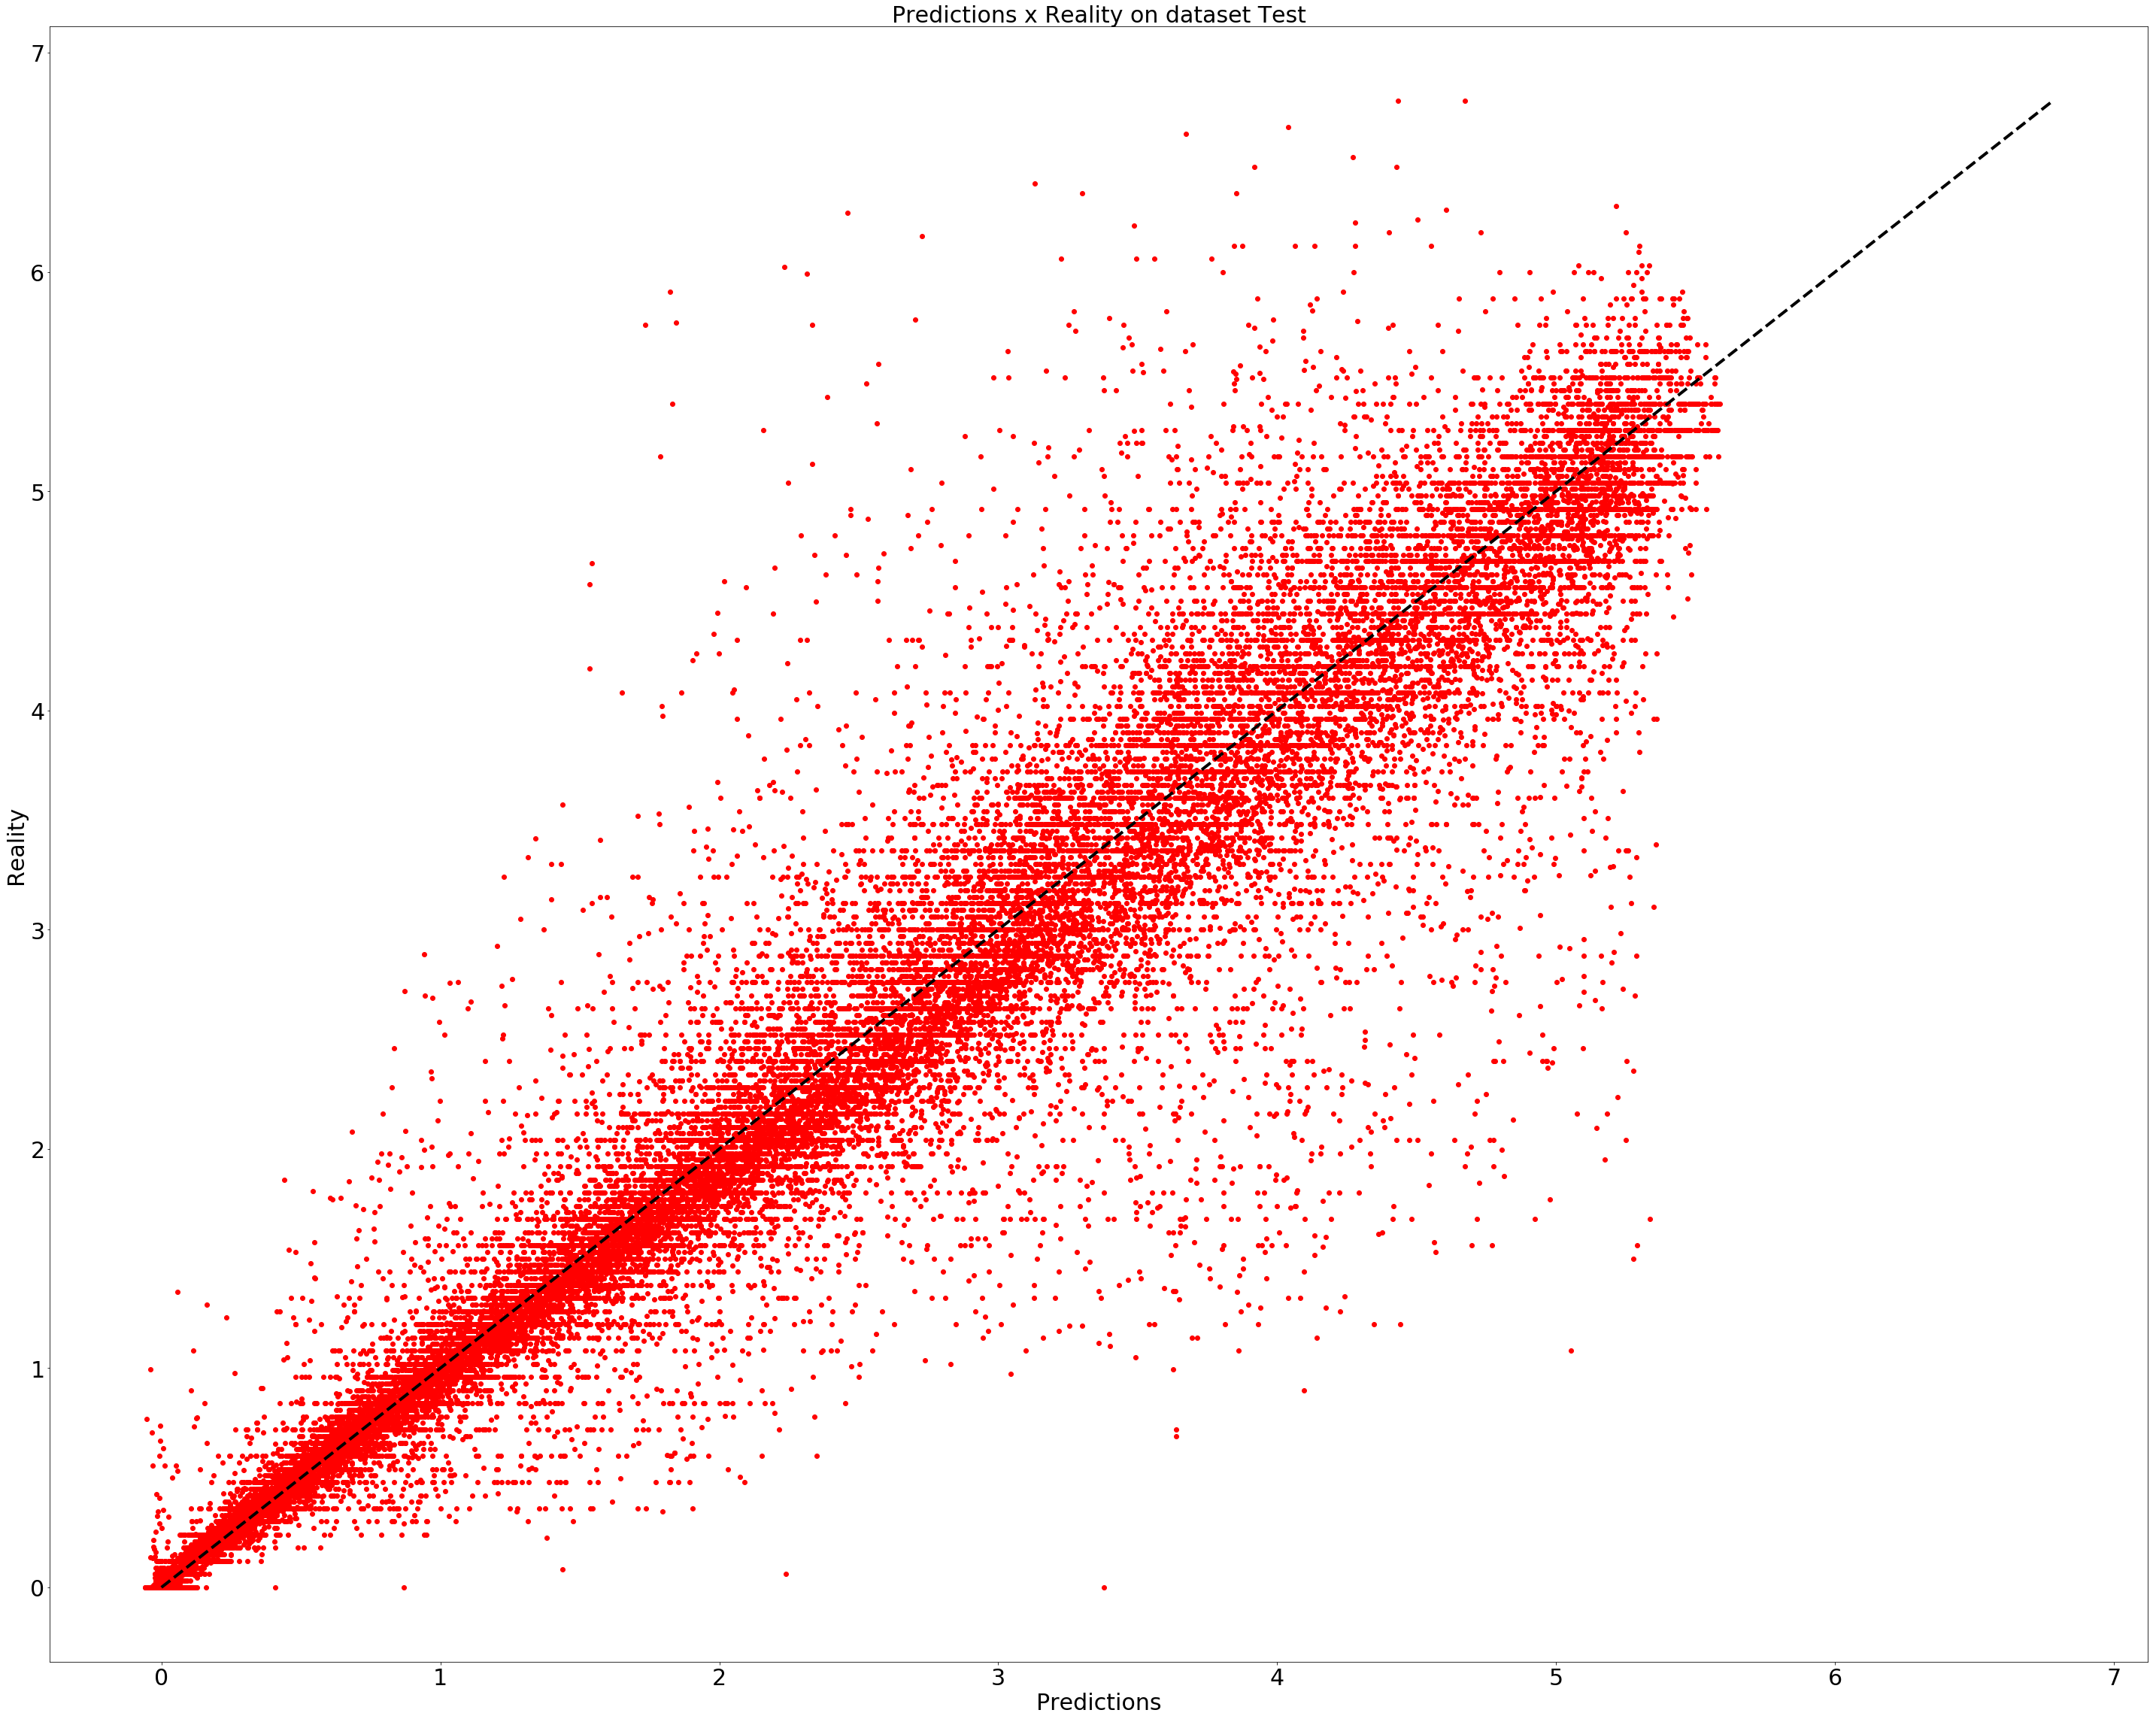

In [97]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

# Predict ค่าบน Unseen Data

In [98]:
#นำ test ซึ่งเป็น unseen Data มาทำการ Predict บน model ที่สร้างขึ้น
y_predict = model.predict(np.array(test))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['P'])
    y_predict = y_predict.join(buffer_datetime_test)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "C_model1")